In [10]:
## download songlyrics.zip from Kaggle, requires log in
## https://www.kaggle.com/mousehead/songlyrics/downloads/songlyrics.zip

## tf from scratch: 
## https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [11]:
import logging
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from gensim.models.word2vec import Word2Vec
from nltk import sent_tokenize, word_tokenize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [17]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [18]:
data = pd.read_csv('./data/kaggle_lyrics/songlyrics.zip')
data.drop(columns=['link'], inplace=True)
data.head()

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante","Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


In [19]:
## use kaggle data set on 57,650 songs (check if it has artists for text generation)
artist_names = ['Eric Clapton', 'Jimi Hendrix', 'Bob Dylan', 'Muddy Waters', 'Eagles']
for artist_name in artist_names:
    print('There are {:03d} songs set for {}.'.format(
        len(data[data['artist'].str.contains(artist_name)]), artist_name))

There are 152 songs set for Eric Clapton.
There are 127 songs set for Jimi Hendrix.
There are 188 songs set for Bob Dylan.
There are 000 songs set for Muddy Waters.
There are 041 songs set for Eagles.


In [20]:
## add songs from the Genius catalog, for which we'll train the text generating model
for artist_name in artist_names:
    file_path = './data/lyrics_by_artist/{}.json'.format(
        artist_name.replace(' ',''))
    if os.path.isfile(file_path):
        with open(file_path) as f:
            tmp = json.load(f)
        for i in range(0, len(tmp['artists'][0]['songs'])):
            data = data.append({'artist': artist_name,
                         'song': tmp['artists'][0]['songs'][i]['title'],
                         'text': tmp['artists'][0]['songs'][i]['lyrics']},
                       ignore_index=True)

In [21]:
data.tail()

,artist,song,text
57752,Eagles,Wasted Time,"[Verse]\nWell baby, there you stand\nWith your..."
57753,Eagles,What Do I Do With My Heart,[Verse 1]\nYou don't have to say a word\nI can...
57754,Eagles,Witchy Woman,[Verse 1: Don Henley]\nRaven hair & ruby lips\...
57755,Eagles,You Are Not Alone,[Verse 1]\nSay goodbye to all your pain and so...
57756,Eagles,You Never Cry Like A Lover,[Verse]\nYou never cry like a lover should\nSi...


In [22]:
%%time
data['text'] = data['text'].apply(lambda text: word_tokenize(text.replace('\n', '. ')))

CPU times: user 5min 38s, sys: 832 ms, total: 5min 39s
Wall time: 5min 58s


In [23]:
%%time
## train word2vec nn to generate embeddings
model = Word2Vec(data['text'].tolist(), size=128, window=10, min_count=10, workers=6, sg=0, hs=0)
model.train(data['text'].tolist(), total_examples=len(data['text']), epochs=10)
# note: sg=0,1 (skip gram or cbow by default)
# note: hs=0,1 (hierarchical softmax or negative sampling by default)

model.wv.most_similar(positive=['man', 'cold'], negative=[], topn=5)

2018-09-05 15:18:09,759 : INFO : collecting all words and their counts
2018-09-05 15:18:09,772 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-09-05 15:18:10,760 : INFO : PROGRESS: at sentence #10000, processed 2843150 words, keeping 46342 word types
2018-09-05 15:18:11,550 : INFO : PROGRESS: at sentence #20000, processed 5778998 words, keeping 69244 word types
2018-09-05 15:18:12,389 : INFO : PROGRESS: at sentence #30000, processed 8605139 words, keeping 86151 word types
2018-09-05 15:18:13,279 : INFO : PROGRESS: at sentence #40000, processed 11562789 words, keeping 101802 word types
2018-09-05 15:18:14,017 : INFO : PROGRESS: at sentence #50000, processed 14573663 words, keeping 117756 word types
2018-09-05 15:18:14,628 : INFO : collected 127711 word types from a corpus of 16860404 raw words and 57757 sentences
2018-09-05 15:18:14,636 : INFO : Loading a fresh vocabulary
2018-09-05 15:18:14,805 : INFO : min_count=10 retains 24189 unique words (18% of ori

2018-09-05 15:19:08,453 : INFO : EPOCH 2 - PROGRESS: at 83.92% examples, 375351 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:19:09,457 : INFO : EPOCH 2 - PROGRESS: at 87.10% examples, 374810 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:19:10,492 : INFO : EPOCH 2 - PROGRESS: at 90.97% examples, 375545 words/s, in_qsize 12, out_qsize 0
2018-09-05 15:19:11,505 : INFO : EPOCH 2 - PROGRESS: at 94.19% examples, 374319 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:19:12,524 : INFO : EPOCH 2 - PROGRESS: at 97.55% examples, 373391 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:19:13,333 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-09-05 15:19:13,340 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-09-05 15:19:13,349 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-05 15:19:13,356 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-05 15:19:13,360 : INFO : worker thread finished; awaiting 

2018-09-05 15:20:10,642 : INFO : EPOCH 4 - PROGRESS: at 99.41% examples, 381188 words/s, in_qsize 12, out_qsize 1
2018-09-05 15:20:10,774 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-09-05 15:20:10,787 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-09-05 15:20:10,795 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-05 15:20:10,854 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-05 15:20:10,880 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-05 15:20:10,891 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-05 15:20:10,892 : INFO : EPOCH - 4 : training on 16860404 raw words (10962857 effective words) took 28.8s, 381035 effective words/s
2018-09-05 15:20:11,932 : INFO : EPOCH 5 - PROGRESS: at 2.72% examples, 288644 words/s, in_qsize 12, out_qsize 1
2018-09-05 15:20:12,989 : INFO : EPOCH 5 - PROGRESS: at 6.14% examples, 317087 words/s,

2018-09-05 15:21:08,093 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-09-05 15:21:08,096 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-05 15:21:08,105 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-05 15:21:08,135 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-05 15:21:08,147 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-05 15:21:08,155 : INFO : EPOCH - 1 : training on 16860404 raw words (10962399 effective words) took 28.9s, 379973 effective words/s
2018-09-05 15:21:09,239 : INFO : EPOCH 2 - PROGRESS: at 3.30% examples, 331504 words/s, in_qsize 10, out_qsize 1
2018-09-05 15:21:10,244 : INFO : EPOCH 2 - PROGRESS: at 6.71% examples, 343385 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:21:11,280 : INFO : EPOCH 2 - PROGRESS: at 10.16% examples, 347906 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:21:12,287 : INFO : EPOCH 2 - PROGRESS: at 13.93% ex

2018-09-05 15:22:05,555 : INFO : EPOCH - 3 : training on 16860404 raw words (10962152 effective words) took 28.6s, 383199 effective words/s
2018-09-05 15:22:06,572 : INFO : EPOCH 4 - PROGRESS: at 3.19% examples, 338466 words/s, in_qsize 10, out_qsize 1
2018-09-05 15:22:07,592 : INFO : EPOCH 4 - PROGRESS: at 6.71% examples, 350886 words/s, in_qsize 12, out_qsize 0
2018-09-05 15:22:08,640 : INFO : EPOCH 4 - PROGRESS: at 10.40% examples, 359793 words/s, in_qsize 12, out_qsize 0
2018-09-05 15:22:09,670 : INFO : EPOCH 4 - PROGRESS: at 13.66% examples, 350683 words/s, in_qsize 9, out_qsize 2
2018-09-05 15:22:10,686 : INFO : EPOCH 4 - PROGRESS: at 16.78% examples, 352284 words/s, in_qsize 12, out_qsize 1
2018-09-05 15:22:11,703 : INFO : EPOCH 4 - PROGRESS: at 19.99% examples, 354137 words/s, in_qsize 10, out_qsize 1
2018-09-05 15:22:12,704 : INFO : EPOCH 4 - PROGRESS: at 23.09% examples, 352691 words/s, in_qsize 12, out_qsize 0
2018-09-05 15:22:13,711 : INFO : EPOCH 4 - PROGRESS: at 26.29% ex

2018-09-05 15:23:08,117 : INFO : EPOCH 6 - PROGRESS: at 15.67% examples, 329045 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:23:09,137 : INFO : EPOCH 6 - PROGRESS: at 18.74% examples, 331842 words/s, in_qsize 12, out_qsize 0
2018-09-05 15:23:10,137 : INFO : EPOCH 6 - PROGRESS: at 22.10% examples, 338980 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:23:11,162 : INFO : EPOCH 6 - PROGRESS: at 25.16% examples, 335917 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:23:12,226 : INFO : EPOCH 6 - PROGRESS: at 28.03% examples, 331671 words/s, in_qsize 9, out_qsize 2
2018-09-05 15:23:13,234 : INFO : EPOCH 6 - PROGRESS: at 31.70% examples, 337662 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:23:14,234 : INFO : EPOCH 6 - PROGRESS: at 35.34% examples, 342369 words/s, in_qsize 9, out_qsize 2
2018-09-05 15:23:15,242 : INFO : EPOCH 6 - PROGRESS: at 38.62% examples, 344486 words/s, in_qsize 12, out_qsize 0
2018-09-05 15:23:16,244 : INFO : EPOCH 6 - PROGRESS: at 41.49% examples, 341032 words/s, i

2018-09-05 15:24:09,867 : INFO : EPOCH 8 - PROGRESS: at 33.31% examples, 353801 words/s, in_qsize 12, out_qsize 4
2018-09-05 15:24:10,872 : INFO : EPOCH 8 - PROGRESS: at 36.85% examples, 354677 words/s, in_qsize 10, out_qsize 1
2018-09-05 15:24:11,884 : INFO : EPOCH 8 - PROGRESS: at 40.16% examples, 357081 words/s, in_qsize 12, out_qsize 1
2018-09-05 15:24:12,896 : INFO : EPOCH 8 - PROGRESS: at 43.24% examples, 353895 words/s, in_qsize 12, out_qsize 0
2018-09-05 15:24:13,951 : INFO : EPOCH 8 - PROGRESS: at 47.40% examples, 357985 words/s, in_qsize 9, out_qsize 2
2018-09-05 15:24:14,953 : INFO : EPOCH 8 - PROGRESS: at 51.13% examples, 359755 words/s, in_qsize 12, out_qsize 0
2018-09-05 15:24:16,002 : INFO : EPOCH 8 - PROGRESS: at 54.33% examples, 357372 words/s, in_qsize 12, out_qsize 1
2018-09-05 15:24:17,009 : INFO : EPOCH 8 - PROGRESS: at 58.14% examples, 360481 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:24:18,104 : INFO : EPOCH 8 - PROGRESS: at 61.81% examples, 359781 words/s, 

2018-09-05 15:25:13,145 : INFO : EPOCH 10 - PROGRESS: at 57.19% examples, 354926 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:25:14,157 : INFO : EPOCH 10 - PROGRESS: at 60.87% examples, 356321 words/s, in_qsize 9, out_qsize 2
2018-09-05 15:25:15,170 : INFO : EPOCH 10 - PROGRESS: at 64.13% examples, 355998 words/s, in_qsize 12, out_qsize 1
2018-09-05 15:25:16,185 : INFO : EPOCH 10 - PROGRESS: at 67.36% examples, 356506 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:25:17,192 : INFO : EPOCH 10 - PROGRESS: at 70.72% examples, 358685 words/s, in_qsize 12, out_qsize 0
2018-09-05 15:25:18,209 : INFO : EPOCH 10 - PROGRESS: at 73.36% examples, 358112 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:25:19,227 : INFO : EPOCH 10 - PROGRESS: at 77.01% examples, 359675 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:25:20,249 : INFO : EPOCH 10 - PROGRESS: at 80.19% examples, 358134 words/s, in_qsize 11, out_qsize 0
2018-09-05 15:25:21,255 : INFO : EPOCH 10 - PROGRESS: at 83.40% examples, 356953 

CPU times: user 15min 18s, sys: 1.25 s, total: 15min 19s
Wall time: 7min 16s


In [24]:
## build vocab and embedding matrix
vocab = list(model.wv.vocab)
embedding_matrix = model.wv[vocab] # shape = [vocab_size, embedding_size]
df = pd.DataFrame(embedding_matrix, index=vocab, columns=[
    'comp'+str(i) for i in range(0, embedding_matrix.shape[1])])
print('{} words picked up.'.format(len(vocab)))

24189 words picked up.


In [25]:
## save vocabulary and embedding matrix
np.save('./data/vocab.npy', vocab)
np.save('./data/embedding_matrix.npy', embedding_matrix)

In [26]:
def find_clustered_embeddings(embeddings, distance_threshold, sample_threshold):
    ''' 
    Find only the closely clustered embeddings. 
    This gets rid of more sparsly distributed word embeddings and make the visualization clearer
    This is useful for t-SNE visualization
    
    distance_threshold: maximum distance between two points to qualify as neighbors
    sample_threshold: number of neighbors required to be considered a cluster
    '''
    
    # calculate cosine similarity
    cosine_sim = np.dot(embeddings,np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings**2,axis=1).reshape(-1,1),np.sum(np.transpose(embeddings)**2,axis=0).reshape(1,-1))
    assert cosine_sim.shape == norm.shape
    cosine_sim /= norm
    
    # make all the diagonal entries zero otherwise this will be picked as highest
    np.fill_diagonal(cosine_sim, -1.0)
    
    argmax_cos_sim = np.argmax(cosine_sim, axis=1)
    mod_cos_sim = cosine_sim
    # find the maximums in a loop to count if there are more than n items above threshold
    for _ in range(sample_threshold-1):
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]),argmax_cos_sim] = -1
    
    max_cosine_sim = np.max(mod_cos_sim,axis=1)

    return np.where(max_cosine_sim>distance_threshold)[0]

In [27]:
%%time
## tsne and visualize
num_embeddings = 4000
selected_embeddings = embedding_matrix[:num_embeddings,:]

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, verbose=1).fit_transform(
    selected_embeddings)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.018s...
[t-SNE] Computed neighbors for 4000 samples in 5.469s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 2.371225
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.527489
[t-SNE] Error after 2500 iterations: 2.536569
CPU times: user 5min 40s, sys: 12.9 s, total: 5min 53s
Wall time: 6min 34s


In [28]:
print('Pruning the T-SNE embeddings')
# prune the embeddings by getting ones only more than n-many sample above the similarity threshold
# this unclutters the visualization
selected_ids = find_clustered_embeddings(selected_embeddings, 0.03, 1)
tsne_plot = tsne[selected_ids,:]

print('Out of ', num_embeddings, ' samples, ',
      selected_ids.shape[0],' samples were selected by pruning.')

Pruning the T-SNE embeddings
Out of  4000  samples,  295  samples were selected by pruning.


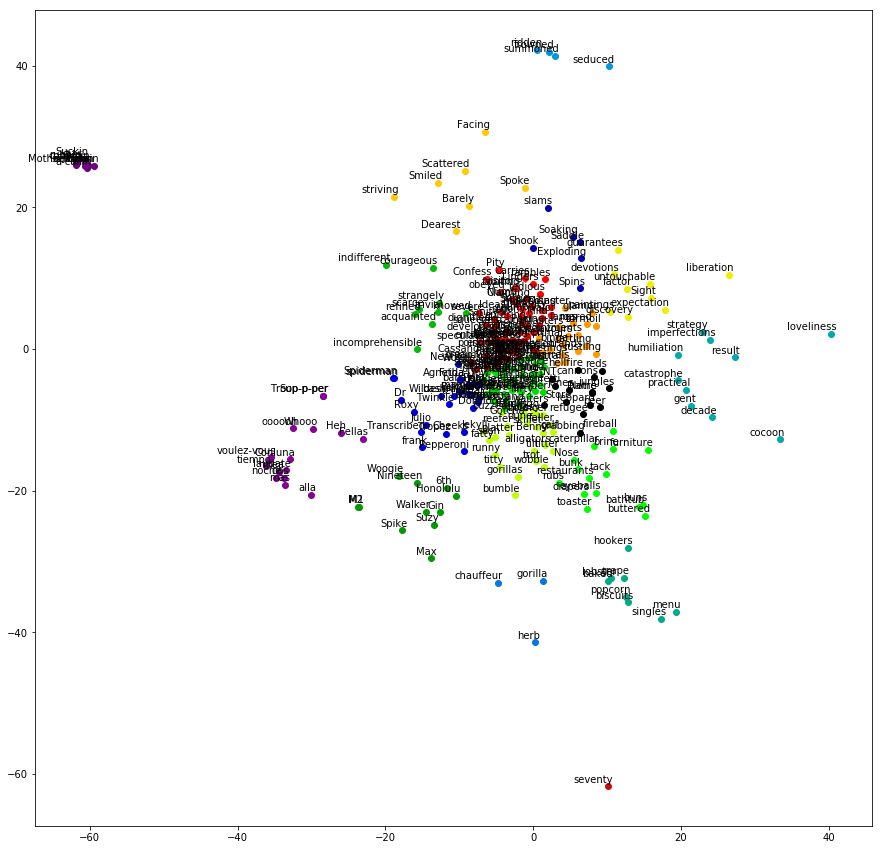

In [29]:
def plot_tsne(embeddings, labels):

    n_clusters = 20 # number of clusters

    # automatically build a discrete set of colors, each for cluster
    color_map = plt.get_cmap('nipy_spectral')
    label_colors = [color_map(float(i)/n_clusters) for i in range(n_clusters)]

    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'

    # Define K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(embeddings)
    kmeans_labels = kmeans.labels_

    plt.figure(figsize=(15,15))  # in inches

    # plot all the embeddings and their corresponding words
    for i, (label,klabel) in enumerate(zip(labels,kmeans_labels)):
        x, y = embeddings[i,:]
        plt.scatter(x, y, c=label_colors[klabel])    

        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom',fontsize=10)

    # use for saving the figure if needed
    #plt.savefig('word_embeddings.png')
    plt.show()

vocab_plot = [vocab[i] for i in selected_ids]
plot_tsne(tsne_plot, vocab_plot)